In [1]:
%load_ext autoreload
%autoreload 2
import os, csv, sys
sys.path.append('..')
from fewshot.allmodels import all_models
from fewshot.utils import load_config, set_seed
from fewshot.problems.toy_gaussian import ToyGaussianBenchmark

import math
import numpy as np
import time

# Load benchmark problem and generate dataset
problem_params = load_config('../fewshot/problems/toy_gaussian_config.yaml')
variants = list(problem_params['variants'].keys())
print("Available variants:",variants)
#variant options
#problem_variant = ['with_derivative','out_distribution','noisy','with_displacement']
problem_variant = 'with_derivative'
#problem_variant = None
print("Chosen variant",problem_variant)
benchmark = ToyGaussianBenchmark(problem_variant)

learning_problem = benchmark.problem()
print("Input dimensions",learning_problem.input_shape)
print("Output dimensions",learning_problem.output_shape)
t0 = time.time()
train_set, val_set, test_set = benchmark.dataset()
t1 = time.time()
print("Time to generate dataset: %0.2fs" % (t1-t0))
print(len(train_set),"training tasks",sum(len(train_set[s]) for s in range(len(train_set))),"examples")
print(len(val_set),"validation tasks",sum(len(val_set[s]) for s in range(len(val_set))),"examples")
print(len(test_set),"testing tasks",sum(len(test_set[s]) for s in range(len(test_set))),"examples")

Available variants: ['out_distribution', 'noisy', 'with_derivative', 'with_displacement']
Chosen variant with_derivative
Input dimensions (1,)
Output dimensions (2,)
Time to generate dataset: 2.64s
72 training tasks 7272 examples
18 validation tasks 1818 examples
90 testing tasks 9090 examples


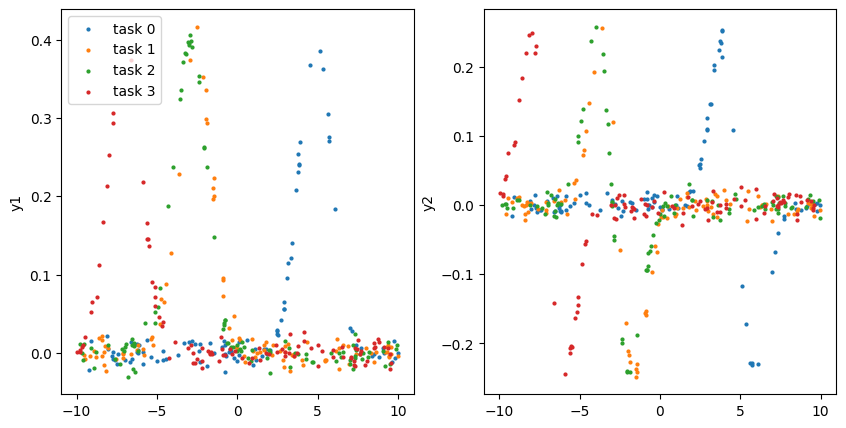

In [2]:
#Plot some tasks
import matplotlib.pyplot as plt

nchannels = learning_problem.output_shape[0]
fig,axs = plt.subplots(1,nchannels,figsize=(5*nchannels,5))
if not hasattr(axs,'__iter__') or isinstance(axs,plt.Axes):
    axs = [axs]
for dim in range(nchannels):
    ax = axs[dim]
    ax.set_ylabel('y'+str(1+dim))
    for i in range(4):
        task = train_set[i]
        x = [ex[0][0] for ex in task]
        y = [ex[1][dim] for ex in task]
        ax.scatter(x,y,s=4,label='task %d'%i)
axs[0].legend()
plt.show()

In [7]:
# Create a model and train it

#load the standard parameteters for "standard" GP training on the flattened dataset
if problem_variant is not None:
    gp_params = load_config('../configs/MOGP_flat.yaml')
else:
    gp_params = load_config('../configs/GP_flat.yaml')
gp_params['num_workers'] = 0
gp_params['epochs'] = 10
#create the model and train it
model = all_models()['GP'](learning_problem,gp_params)

SMOKE_TEST = False
if SMOKE_TEST:
    gp_params['epochs'] = 1
    train_set = train_set.subsample(0.1)
    val_set = val_set.subsample(0.1)

# Show the parameters to be tuned
for k,v in model.model.state_dict().items():
    if len(v.shape)==0 or len(v) < 5:
        print(k,":",v)
    else:
        print(k,":",v.shape,"elements")

model.train(train_set,val_set)

gmodel.likelihood.raw_task_noises : tensor([0., 0.])
gmodel.likelihood.raw_task_noises_constraint.lower_bound : tensor(1.0000e-04)
gmodel.likelihood.raw_task_noises_constraint.upper_bound : tensor(inf)
gmodel.mean_module.base_means.0.raw_constant : tensor(0.)
gmodel.mean_module.base_means.1.raw_constant : tensor(0.)
gmodel.task_covar_module.covar_factor : tensor([[ 0.5664,  0.9327],
        [-0.9193,  0.1242]])
gmodel.task_covar_module.raw_var : tensor([-0.9220,  0.7319])
gmodel.task_covar_module.raw_var_constraint.lower_bound : tensor(0.)
gmodel.task_covar_module.raw_var_constraint.upper_bound : tensor(inf)
gmodel.covar_module.raw_outputscale : tensor(0.)
gmodel.covar_module.base_kernel.raw_lengthscale : tensor([[0.]])
gmodel.covar_module.base_kernel.raw_lengthscale_constraint.lower_bound : tensor(0.)
gmodel.covar_module.base_kernel.raw_lengthscale_constraint.upper_bound : tensor(inf)
gmodel.covar_module.raw_outputscale_constraint.lower_bound : tensor(0.)
gmodel.covar_module.raw_outpu

100%|██████████| 6/6 [00:00<00:00, 14.98batch/s]


Epoch loss: 0.8105787721685169, Epoch MAE: 0.0005650589139829093


  0%|          | 0/1 [00:00<?, ?batch/s]c:\Python311\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 17.14batch/s]


Val loss: 0.5580971240997314, Val MAE: 0.00015641088680465624
Epoch 1


100%|██████████| 6/6 [00:00<00:00, 12.56batch/s]


Epoch loss: 0.5014173993379762, Epoch MAE: 0.000543249789440986


100%|██████████| 1/1 [00:00<00:00, 55.84batch/s]


Val loss: 0.2952196002006531, Val MAE: 0.00023386289946513602
Epoch 2


100%|██████████| 6/6 [00:00<00:00, 16.93batch/s]


Epoch loss: 0.22405854267986358, Epoch MAE: 0.0005731571365616783


100%|██████████| 1/1 [00:00<00:00, 35.41batch/s]


Val loss: 0.02068147622048855, Val MAE: 0.00025322553840014016
Epoch 3


100%|██████████| 6/6 [00:00<00:00, 15.26batch/s]


Epoch loss: -0.06126163712316726, Epoch MAE: 0.0005527474407680975


100%|██████████| 1/1 [00:00<00:00, 45.49batch/s]


Val loss: -0.2576608955860138, Val MAE: 0.0003237619922302737
Epoch 4


100%|██████████| 6/6 [00:00<00:00, 17.41batch/s]


Epoch loss: -0.3339341250386569, Epoch MAE: 0.0005414395986975841


100%|██████████| 1/1 [00:00<00:00, 34.63batch/s]


Val loss: -0.5201881527900696, Val MAE: 0.0003321235722834521
Epoch 5


100%|██████████| 6/6 [00:00<00:00, 18.09batch/s]


Epoch loss: -0.5744362545148318, Epoch MAE: 0.0005412825200142921


100%|██████████| 1/1 [00:00<00:00, 45.84batch/s]


Val loss: -0.7216227054595947, Val MAE: 0.0003693147313476789
Epoch 6


100%|██████████| 6/6 [00:00<00:00, 17.46batch/s]


Epoch loss: -0.7462033624359034, Epoch MAE: 0.0005717986912757707


100%|██████████| 1/1 [00:00<00:00, 50.54batch/s]


Val loss: -0.8458688855171204, Val MAE: 0.0004405634164220036
Epoch 7


100%|██████████| 6/6 [00:00<00:00, 15.15batch/s]


Epoch loss: -0.8311662331666096, Epoch MAE: 0.0005730523858245731


100%|██████████| 1/1 [00:00<00:00, 53.42batch/s]


Val loss: -0.8781803250312805, Val MAE: 0.0003530010212175917
Epoch 8


100%|██████████| 6/6 [00:00<00:00, 17.20batch/s]


Epoch loss: -0.8285828231922133, Epoch MAE: 0.0006164154393500958


100%|██████████| 1/1 [00:00<00:00, 40.15batch/s]


Val loss: -0.8571929931640625, Val MAE: 0.0003247119412563815
Epoch 9


100%|██████████| 6/6 [00:00<00:00, 16.02batch/s]


Epoch loss: -0.8134850903481371, Epoch MAE: 0.0005675913895120715


100%|██████████| 1/1 [00:00<00:00, 46.15batch/s]

Val loss: -0.8776319026947021, Val MAE: 0.0003288760412447523


In [8]:

# Show the parameters generated
if model.model.params.get('multi_output',False):
    print("Output scale",model.model.gmodel.covar_module.outputscale)
    print("Length scale",model.model.gmodel.covar_module.base_kernel.lengthscale)
    print("Noise",model.model.gmodel.likelihood.task_noises)
    print("Constant",np.array([m.constant.detach().numpy() for m in model.model.gmodel.mean_module.base_means]))
    print("Cross-covar",model.model.gmodel.task_covar_module.covar_matrix.numpy())   
else:
    for i in range(nchannels):
        print("Output channel {} ({})".format(i,learning_problem.output_vars[i]))
        print("  Output scale",model.model.gmodel.channel_models.models[i].covar_module.outputscale)
        print("  Length scale",model.model.gmodel.channel_models.models[i].covar_module.base_kernel.lengthscale)
        print("  Noise",model.model.gmodel.channel_models.models[i].likelihood.noise)
        print("  Constant",model.model.gmodel.channel_models.models[i].mean_module.constant)

#for k,v in model.model.state_dict().items():
#    print(k,":",v)

Output scale tensor(0.0239, grad_fn=<SoftplusBackward0>)
Length scale tensor([[2.7374]], grad_fn=<SoftplusBackward0>)
Noise tensor([0.0085, 0.0078], grad_fn=<AddBackward0>)
Constant [ 0.00170504 -0.01588304]
Cross-covar [[ 0.27513176 -0.0065858 ]
 [-0.0065858   0.07024191]]


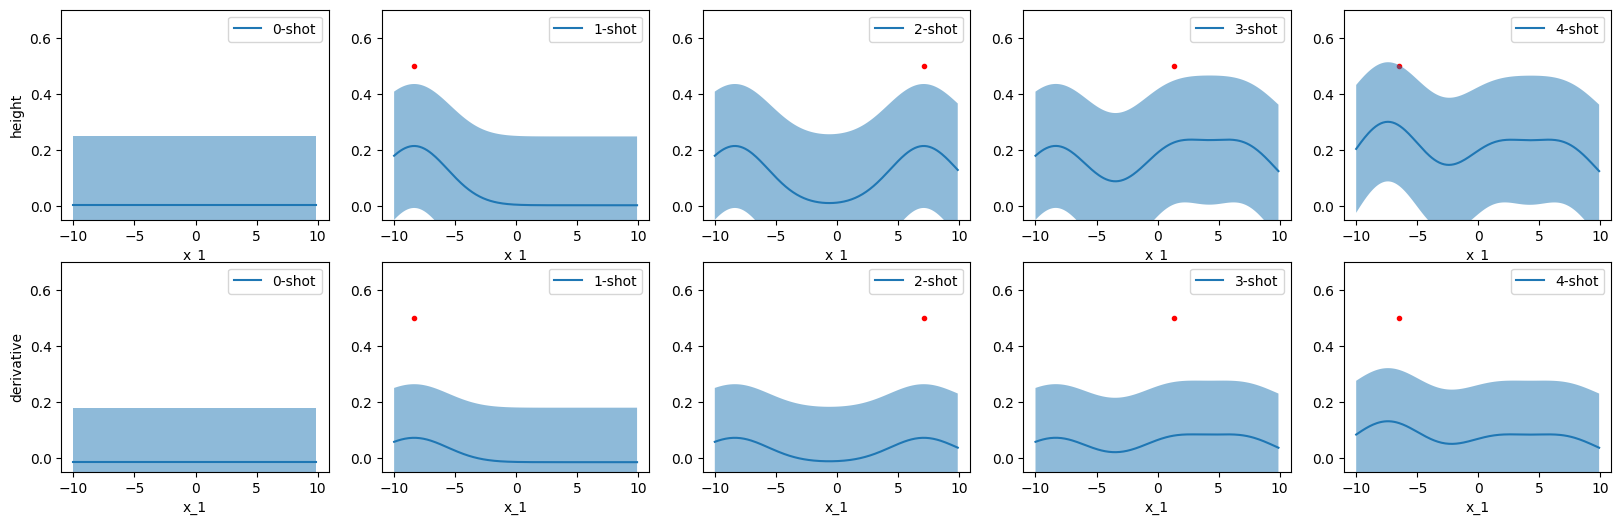

In [9]:
# Show how the model adapts on over k shots on the test set, using a synthetic y value
from fewshot.plotting import plot_k_shot_preds

#synthetic_y = None
synthetic_y = np.array([0.5]*nchannels)

xs = np.arange(-10.0,10.0,0.1)
supp_set = [(x,synthetic_y) for x,y in test_set[0][:5]]
plot_k_shot_preds(learning_problem,model,xs,supp_set)
plt.show()

In [ ]:
# Evaluate the model -- obviously it's not performing very well
from fewshot.plotting import plot_k_shot_accuracy

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
plot_k_shot_accuracy(model,test_set,k_shot=10,ax=ax)
plt.show()

In [ ]:
# Now try doing few-shot training
#load the standard parameteters for "standard" GP training on the flattened dataset
if problem_variant is not None:
    gp_params = load_config('../configs/MOGP_fs.yaml')
else:
    gp_params = load_config('../configs/GP_fs.yaml')
gp_params['num_workers'] = 0
gp_params['epochs'] = 10
#create the model and train it
model = all_models()['GP'](learning_problem,gp_params)
model.train(train_set,val_set)
model.model.eval()
# Show the parameters generated
print("Output scale",model.model.gmodel.channel_models.models[0].covar_module.outputscale)
print("Length scale",model.model.gmodel.channel_models.models[0].covar_module.base_kernel.lengthscale)
print("Noise",model.model.gmodel.channel_models.models[0].likelihood.noise_covar.noise)
print("Constant",model.model.gmodel.channel_models.models[0].mean_module.constant)

In [ ]:
# Show how the model adapts on over k shots on the test set, using a synthetic y value
xs = np.arange(-10,10,0.1)
plot_k_shot_preds(learning_problem,model,xs,supp_set)
plt.show()

In [ ]:
# Evaluate the model -- now it's performing much better
from fewshot.plotting import plot_k_shot_accuracy
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
plot_k_shot_accuracy(model,test_set,k_shot=10,ax=ax)
plt.show()

In [ ]:
#model-zoo test

model_configs = {}
seed = 1

# Training
config_names = list(all_models().keys())
config_names += ['FSGP','DNNResidualFSGP','MOGP']
for config_name in config_names:
    method_name = config_name
    if 'FSGP' in method_name:
        method_name = method_name.replace('FSGP','GP')
    if 'MOGP' in method_name:
        method_name = method_name.replace('MOGP','GP')
    try:
        method_params = load_config(f'../configs/{config_name}/toy_gaussian_config.yaml')
    except FileNotFoundError:
        try:
            method_params = load_config(f'../configs/{config_name}/config.yaml')
        except FileNotFoundError:
            method_params = load_config(f'../fewshot/{method_name}/config.yaml')
    method_params['log_dir'] = 'log_dir'
    method_params['seed'] = seed
    method_params['num_workers'] = 0
    if method_name in ['DKL','DNNFineTuning']:  #non few-shot
        method_params['k_shot'] = None
        model_configs[config_name] = method_params
    elif method_name in ['DNNResidualGP','GP']:
        #test multiple variants.  Standard, few-shot, and multi-output
        method_params['k_shot'] = None
    elif 'FSGP' in method_name:
        method_params['k_shot'] = 5
    elif 'MOGP' in method_name:
        assert method_params['multi_output']
    else:
        method_params['k_shot'] = 5   #train with 5 shot
    model_configs[config_name] = (method_name,method_params)

print("Training the following model configurations:")
for config_name, method_params in model_configs.items():
    print("  ",config_name,":",method_params)

for config_name, (method_name,method_params) in model_configs.items():
    method_params['checkpoint_dir'] = f'../checkpoint_dir/toy_gaussian_{config_name}/'
    method = all_models()[method_name]
    try:
        model = method(learning_problem, method_params)
        print(f'Training {config_name}...')
        model.train(train_set, val_set)
        model.save()
    except Exception as e:
        print("Error while evaluating",config_name)
        print(e)
        import traceback
        traceback.print_exc()
    print()

In [ ]:
# Decision-making Testing
from fewshot.decisions.problems.toy_gaussian import ToyGaussianBenchmark
from fewshot.decisions.decisionmaker import RandomDecisionMaker, UCBDecisionMaker
from fewshot.decisions.testing import test_accuracy, test_rollout


with open('toy_gaussian.csv', 'w') as csvfile:
    logger = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    logger.writerow('100 max iters, score threshold -inf')
    logger.writerow(['Model Name', 'Side Info', 'Generalization', 'Exploration', 'Support Size','Mean Attempts', 'Std Attempts', 'Mean Success Rate', 'Std Success Rate'])
    for modelname, method in all_models().items():
        if modelname in ['ADKL', 'CNP', 'FewShotSR']: sinfos = sinfos
        else: sinfos = [None]

        for side_info in sinfos:
            for generalization in ['in', 'out']:
                for exploration in ['Greedy', 'UCB','Random']:
                    if modelname in ['DKL','DNNFineTuning','DNNResidualGP','GP']: sizes = [None]
                    else: sizes = sizes
                    for support_size in sizes:

                        attempts_counts = []
                        success_rates = []

                        if isinstance(support_size, (int, type(None))):
                            support_size_text = 'fixed'
                        else:
                            support_size_text = 'vary'
                        for seed in testing_seeds:
                            benchmark_params['seed'] = seed
                            benchmark_params['sideinfo'] = side_info
                            benchmark_params['generalization'] = generalization
                            benchmark_params['max_iters'] = 100
                            set_seed(seed)
                            benchmark = ToyGaussianBenchmark(benchmark_params, 0.8)
                            task = benchmark.task()
                            test_data = benchmark.test_data()
                            method_params = load_config(f'fewshot/{modelname}/toy_gaussian_config.yaml')
                            method_params['seed'] = seed
                            method_params['k_shot'] = support_size
                            method_params['checkpoint_dir'] = f'checkpoint_dir/{task.name}_{side_info}_{modelname}_{support_size_text}_{seed}/'
                            fn = os.path.join(method_params['checkpoint_dir'], 'best_model.tar')
                            if modelname in ['GP', 'DKL']:
                                model = method(task, method_params, benchmark_params=benchmark_params)
                            else:
                                model = method(task, method_params)
                            model.load(fn)

                            # rollout
                            actions = benchmark.action_set()
                            if exploration == 'UCB':
                                policy = UCBDecisionMaker(task,actions,model,upper_confidence_scale=2.0, terminate_threshold=-math.inf)
                                policy.enumerate_actions = True
                            elif exploration == 'Greedy':
                                policy = UCBDecisionMaker(task,actions,model,upper_confidence_scale=0.0, terminate_threshold=-math.inf)
                                policy.enumerate_actions = True
                            elif exploration == 'Random':
                                policy = RandomDecisionMaker(task, actions)
                                policy.enumerate_actions = True

                            test_envs = benchmark.test_environments()
                            mu_stars = []
                            stds = []
                            for test_env in test_envs:
                                mu_stars.append(test_env.mu)
                                stds.append(test_env.std)
                            print(f'Testing {modelname} sinfo:{side_info}\tsupport:{support_size_text}\tseed:{seed} generalization:{generalization} exploration:{exploration}...')

                            res = test_rollout(task,policy,test_envs)
                            attempts_counts.append(res['numsteps']['average'])
                            success_rates.append(res['successrates']['average'])
                            
                        mean_attempts = np.mean(attempts_counts)
                        std_attempts = np.std(attempts_counts)
                        mean_success_rate = np.mean(success_rates)
                        std_success_rate = np.std(success_rates)
                        logger.writerow([modelname, side_info, generalization, exploration, support_size_text, mean_attempts, std_attempts, mean_success_rate, std_success_rate])
